In [1]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import quantile_transform

# clip then min-max rescale?
minmax = False

## Load the data

In [2]:
census_path = 'data/census_data.csv'
indicators_path = 'data/tracts_indicators_grades.csv'
tracts_path = 'data/tracts_shapefile'
ztrax_year_path = 'data/ztrax_years.csv'
output_path = 'data/tracts_indicators_grades_eras_index.csv'

crs = {'init':'epsg:4326'}

In [3]:
# tract-level census data
cd = pd.read_csv(census_path, dtype={'geoid':str, 'state':str, 'county':str})
cd.shape

(73056, 26)

In [4]:
# tract-level hisdac-us vintage data from ztrax
ztrax = pd.read_csv(ztrax_year_path, dtype={'GEOID':str})
ztrax.shape

(68758, 6)

In [5]:
# tract-level street network indicators
indicators = pd.read_csv(indicators_path, dtype={'geoid':str})
indicators.shape

(72663, 18)

In [6]:
indicators = pd.merge(indicators, ztrax, left_on='geoid', right_on='GEOID', how='left')
indicators = pd.merge(indicators, cd, left_on='geoid', right_on='geoid', how='inner')
indicators.shape

(72663, 49)

In [7]:
tracts = gpd.read_file(tracts_path, crs=crs).rename(columns={'ALAND':'aland'})[['GEOID', 'aland']]
tracts.shape

(74133, 2)

In [8]:
gdf = gpd.GeoDataFrame(pd.merge(indicators, tracts, left_on='geoid', right_on='GEOID'), crs=crs)
gdf = gdf.drop(columns=['GEOID_x', 'GEOID_y'])
gdf.shape

(72663, 49)

In [9]:
with open('data/states_by_fips.json') as f:
    fips_to_state = json.load(f)
gdf['state_abbrev'] = gdf['state'].map(lambda x: fips_to_state[x]['abbreviation'])

In [10]:
gdf.head()

,geoid,orientation_order,orientation_entropy,circuity_avg,k_avg,prop_deadend,prop_4way,m,n,length_median,...,prop_1960_69,prop_1970_79,prop_1980_89,prop_1990_99,prop_2000_09,prop_2010_later,state,county,aland,state_abbrev
0,01001020100,0.133914,3.431114,1.056441,2.297143,0.274286,0.062857,201,175,137.2530,...,0.122,0.164,0.258,0.159,0.122,0.000,01,001,9817812,AL
1,01001020200,0.593215,2.787678,1.026853,2.510949,0.218978,0.175182,172,137,123.5930,...,0.211,0.308,0.034,0.112,0.080,0.000,01,001,3325679,AL
2,01001020300,0.458073,3.003797,1.045833,2.449438,0.241573,0.174157,218,178,122.2380,...,0.204,0.360,0.070,0.165,0.084,0.038,01,001,5349273,AL
3,01001020400,0.277759,3.253601,1.054723,2.729730,0.171171,0.207207,303,222,115.9710,...,0.343,0.328,0.032,0.136,0.010,0.033,01,001,6384276,AL
4,01001020500,0.218907,3.328190,1.089604,2.446701,0.307107,0.139594,482,394,107.4215,...,0.032,0.038,0.122,0.281,0.477,0.050,01,001,11408873,AL


## Create and convert variables

In [11]:
# convert land area and densities to square kilometers
gdf['aland'] = gdf['aland'] / 1e6 #convert m2 to km2
gdf['intersect_density'] = (gdf['n'] / gdf['aland']) * (1 - gdf['prop_deadend']) #per km2
gdf['pop_density'] = gdf['total_pop'] / gdf['aland'] #per km2
gdf['aland'] = gdf['aland'] / 1000 #finally convert km2 to 1000s of km2

In [12]:
# population in units of 1,000 persons
gdf['total_pop_k'] = gdf['total_pop'] / 1000

In [13]:
# log of mean street segment length
gdf['length_mean_log'] = np.log(gdf['length_mean'])

In [14]:
# straightness is inverse of circuity
gdf['straightness'] = 1 / gdf['circuity_avg']

In [15]:
# create state dummies
states = gdf['state_abbrev'].unique()
for state in states:
    gdf[state] = gdf['state_abbrev'].map(lambda x: 1 if x==state else 0)

In [16]:
# dummy for if tract is rural vs urban
# census bureau considers a block urban if it has at least 1000 people per sq mile
urban_density = 1000 / 2.59 # 1000 people per sq mile converted to sq km
gdf['is_urban'] = (gdf['pop_density'] > urban_density).astype(int)
gdf['is_urban'].value_counts()

1    46362
0    26301
Name: is_urban, dtype: int64

In [17]:
gdf['pop_density'] = gdf['pop_density'] / 1000 #1000s of persons per km2
gdf['med_hh_income'] = gdf['med_hh_income'] / 1000 #1000s of USD

## Create grid index

The components themselves have very different variances. Before we combine them into an index, we need to re-scale them so that they contribute more equally to the variance of the index. We use three methods.

  1. clipped +/- *n* std devs above/below the mean, then min-max scaled (this is the "main" grid index)
  2. standardized then min-max scaled (this is a robustness check)
  3. quantile-transformed then min-max scaled (this is a 2nd robustness check)

In [18]:
# create gdf_index so normalization for index doesn't appear in all subsequent variable's analysis
index_components = ['orientation_order', 'straightness', 'prop_4way']
gdf_index = gdf[index_components].copy()
gdf_index.describe()

,orientation_order,straightness,prop_4way
count,72659.000000,72663.000000,72663.000000
mean,0.484327,0.935759,0.210324
std,0.316234,0.045987,0.171770
min,0.002183,0.000000,0.000000
25%,0.185824,0.911671,0.092486
50%,0.465526,0.939706,0.156627
75%,0.772004,0.969004,0.271676
max,1.000000,1.000007,1.000000


1. Create clipped, min-max scaled grid index. This is the main calculation method.

In [19]:
# clip vectors to *sigma* std devs above/below mean to make variances more similar
# then min-max scale to get them into (0,1) range
if minmax:
    sigma = 3
    for col in index_components:
        lower = gdf_index[col].mean() - gdf_index[col].std() * sigma
        upper = gdf_index[col].mean() + gdf_index[col].std() * sigma
        gdf_index[col] = gdf_index[col].clip(lower, upper)

    # min-max scaling
    gdf_index = (gdf_index - gdf_index.min()) / (gdf_index.max() - gdf_index.min())

In [20]:
# fix any rounding errors so all three components are in range 0 to 1
gdf_index = gdf_index.clip(lower=0, upper=1)
gdf_index.describe()

,orientation_order,straightness,prop_4way
count,72659.000000,72663.000000,72663.000000
mean,0.484327,0.935759,0.210324
std,0.316234,0.045987,0.171770
min,0.002183,0.000000,0.000000
25%,0.185824,0.911671,0.092486
50%,0.465526,0.939706,0.156627
75%,0.772004,0.969004,0.271676
max,1.000000,1.000000,1.000000


2. As a robustness test, calculate grid index from normalized components.

In [21]:
# standardized (mean-normalized) version with mean=0 and std=1, then min-max scaled from 0 to 1
gdf_index_norm = (gdf_index - gdf_index.mean()) / gdf_index.std()
gdf_index_norm = (gdf_index_norm - gdf_index_norm.min()) / (gdf_index_norm.max() - gdf_index_norm.min())
gdf_index_norm.describe()

,orientation_order,straightness,prop_4way
count,72659.000000,72663.000000,72663.000000
mean,0.483199,0.935759,0.210324
std,0.316926,0.045987,0.171770
min,0.000000,0.000000,0.000000
25%,0.184042,0.911671,0.092486
50%,0.464356,0.939706,0.156627
75%,0.771505,0.969004,0.271676
max,1.000000,1.000000,1.000000


3. As a second robustness test, calculate grid index from quantile-transformed components. This scaling method is robust against outliers to make the mins, maxs, and stds nearly identical among the components.

In [22]:
# quantile-transformed version where each vector is output normally-distributed, then min-max scaled from 0 to 1
gdf_index_quant = quantile_transform(gdf_index, output_distribution='normal', copy=True)
gdf_index_quant = pd.DataFrame(gdf_index_quant, columns=gdf_index.columns)
gdf_index_quant = (gdf_index_quant - gdf_index_quant.min()) / (gdf_index_quant.max() - gdf_index_quant.min())
gdf_index_quant.describe()

,orientation_order,straightness,prop_4way
count,72659.000000,72663.000000,72663.000000
mean,0.500952,0.501362,0.500209
std,0.099865,0.101354,0.101840
min,0.000000,0.000000,0.000000
25%,0.435155,0.435136,0.435129
50%,0.499985,0.499988,0.499985
75%,0.564859,0.564850,0.564866
max,1.000000,1.000000,1.000000


#### Now, calculate the grid index itself from its constituent components

In [23]:
# geometric mean, even-weighting of min-max-normalized components
# this is our "main" grid index for analysis
gdf['grid_index'] = stats.mstats.gmean(gdf_index, axis=1)

# alternative: geometric mean, even-weighting of standardized components
gdf['grid_index_norm'] = stats.mstats.gmean(gdf_index_norm, axis=1)

# alternative: geometric mean, even-weighting of quantile-transformed components
gdf['grid_index_quant'] = stats.mstats.gmean(gdf_index_quant, axis=1)

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:330: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [24]:
sample = gdf.sample(n=6, random_state=2)
sample[['geoid', 'state_abbrev', 'grid_index'] + index_components]

,geoid,state_abbrev,grid_index,orientation_order,straightness,prop_4way
25412,18177000800,IN,0.600108,0.743488,0.968931,0.300000
31086,25001014700,MA,0.336798,0.267217,0.863212,0.165625
71361,55025011506,WI,0.401471,0.323960,0.914820,0.218341
9300,06073005700,CA,0.905874,0.991945,0.987850,0.758621
17211,12099007833,FL,0.524014,0.768401,0.893731,0.209524
12809,08123002018,CO,0.463627,0.835084,0.942767,0.126582


In [25]:
# want component indicators that are relevant but not too redundant (ie, strongly correlated)
# here, we see each of our indicators is more strongly correlated with the index than with each other: good
gdf[['grid_index'] + index_components].corr()

,grid_index,orientation_order,straightness,prop_4way
grid_index,1.000000,0.899478,0.663511,0.900373
orientation_order,0.899478,1.000000,0.576998,0.669655
straightness,0.663511,0.576998,1.000000,0.582524
prop_4way,0.900373,0.669655,0.582524,1.000000


## Make era dummies then inspect our columns

In [26]:
def get_ztrax_decade(year):
    if year < 1940:
        return 'prop_1939_earlier'
    elif year >= 1940 and year < 1950:
        return 'prop_1940_49'
    elif year >= 1950 and year < 1960:
        return 'prop_1950_59'
    elif year >= 1960 and year < 1970:
        return 'prop_1960_69'
    elif year >= 1970 and year < 1980:
        return 'prop_1970_79'
    elif year >= 1980 and year < 1990:
        return 'prop_1980_89'
    elif year >= 1990 and year < 2000:
        return 'prop_1990_99'
    elif year >= 2000 and year < 2010:
        return 'prop_2000_09'
    elif year >= 2010 and year < 2020:
        return 'prop_2010_later'

# ztrax decade will be that of the median value of all the earliest-year grid cells intersecting the tract
# that is, of all the grid cells in tract, what is the "typical" earliest property date
gdf['ztrax_decade'] = gdf['year_median'].map(get_ztrax_decade)
ztrax_dummies = pd.get_dummies(gdf['ztrax_decade'], prefix='dummy_ztrax')
gdf[ztrax_dummies.columns] = ztrax_dummies

In [27]:
cols = ['prop_1939_earlier', 'prop_1940_49', 'prop_1950_59', 'prop_1960_69', 
        'prop_1970_79', 'prop_1980_89', 'prop_1990_99', 'prop_2000_09', 'prop_2010_later']

# jitter so we don't get 2 eras with equal value and both are the plurality
np.random.seed(0)
gdf[cols] = gdf[cols].applymap(lambda x: x + np.random.random() * 1e-6)

In [28]:
%%time
# identify the primary decade algorithmically
def find_earliest_threshold(row, cols, threshold):
    for col in cols:
        if row[col] > threshold:
            return col

def determine_primary_decade(row, cols=cols):
    for threshold in [0.5, 0.4, 0.3, 0.2, 0.1]:
        decade = find_earliest_threshold(row, cols, threshold)
        if decade is not None:
            return decade

gdf['primary_decade'] = gdf.apply(determine_primary_decade, axis='columns')
primary_dummies = pd.get_dummies(gdf['primary_decade'], prefix='dummy_primary')
gdf[primary_dummies.columns] = primary_dummies

CPU times: user 16.2 s, sys: 0 ns, total: 16.2 s
Wall time: 16.2 s


In [29]:
%%time
# identify whichever decade is earlier: ztrax or primary
def get_earlier_decade(row):
    primary_decade = row['primary_decade']
    ztrax_decade = row['ztrax_decade']
    
    if pd.isnull(primary_decade) and pd.notnull(ztrax_decade):
        return ztrax_decade
    
    if pd.isnull(ztrax_decade) and pd.notnull(primary_decade):
        return primary_decade
    
    if pd.isnull(primary_decade) and pd.isnull(ztrax_decade):
        return None
    
    if float(primary_decade[5:9]) < float(ztrax_decade[5:9]):
        return primary_decade
    else:
        return ztrax_decade
    
gdf['prim_ztrax_decade'] = gdf.apply(get_earlier_decade, axis=1)
primary_ztrax_earliest_dummies = pd.get_dummies(gdf['prim_ztrax_decade'], prefix='dummy_prim_ztrax')
gdf[primary_ztrax_earliest_dummies.columns] = primary_ztrax_earliest_dummies

CPU times: user 2.92 s, sys: 50 ms, total: 2.97 s
Wall time: 2.97 s


In [30]:
%%time
# identify earliest decade by which cumulatively >50% of tract's structures were built
def determine_earliest_cumulative_decade(row):
    for col in cols:
        if row[col]:
            return col

cs = gdf[cols].cumsum(axis='columns') > 0.50
gdf['cumulative_decade'] = cs.apply(determine_earliest_cumulative_decade, axis='columns')
cumulative_dummies = pd.get_dummies(gdf['cumulative_decade'], prefix='dummy_cumulative')
gdf[cumulative_dummies.columns] = cumulative_dummies

CPU times: user 3.67 s, sys: 10 ms, total: 3.68 s
Wall time: 3.67 s


In [31]:
%%time
# identify earliest decade in which >20% of tract's structures were built
def determine_earliest_decade(row, threshold=0.20):
    for col in cols:
        if row[col] > threshold:
            return col
    
gdf['earliest_decade'] = gdf.apply(determine_earliest_decade, axis='columns')
earliest_dummies = pd.get_dummies(gdf['earliest_decade'], prefix='dummy_earliest')
gdf[earliest_dummies.columns] = earliest_dummies

CPU times: user 3.99 s, sys: 30 ms, total: 4.02 s
Wall time: 4.01 s


In [32]:
%%time
# identify decade in which plurality of tract's structures were built
def determine_plurality_decade(row):
    for col in cols:
        other_cols = [c for c in cols if c != col]
        if (row[col] > row[other_cols]).all():
            return col

gdf['plurality_decade'] = gdf.apply(determine_plurality_decade, axis='columns')
plurality_dummies = pd.get_dummies(gdf['plurality_decade'], prefix='dummy_plurality')
gdf[plurality_dummies.columns] = plurality_dummies

CPU times: user 4min 8s, sys: 30 ms, total: 4min 8s
Wall time: 4min 8s


In [33]:
%%time
# identify decade in which majority of tract's structures were built (where a majority exists)
def determine_majority_decade(row):
    for col in cols:
        if row[col] > 0.5:
            return col

gdf['majority_decade'] = gdf.apply(determine_majority_decade, axis='columns')
majority_dummies = pd.get_dummies(gdf['majority_decade'], prefix='dummy_majority')
gdf[majority_dummies.columns] = majority_dummies

CPU times: user 6.99 s, sys: 0 ns, total: 6.99 s
Wall time: 6.99 s


In [34]:
decades = ['majority_decade', 'plurality_decade', 'earliest_decade', 'cumulative_decade', 'primary_decade', 'ztrax_decade', 'prim_ztrax_decade']
gdf[decades].apply(lambda x: x.value_counts())

,majority_decade,plurality_decade,earliest_decade,cumulative_decade,primary_decade,ztrax_decade,prim_ztrax_decade
prop_1939_earlier,5751,18096,19552,5751,21151,20528,27826
prop_1940_49,85,1139,1636,3913,1550,4976,4411
prop_1950_59,1215,8546,8510,9646,9232,8846,9058
prop_1960_69,544,5356,5730,10479,5645,9269,8224
prop_1970_79,1147,12418,12689,16311,12368,10859,11625
prop_1980_89,984,7377,6986,13813,6951,8807,7169
prop_1990_99,1050,9115,8242,8624,7800,3713,3164
prop_2000_09,1817,9623,4715,3596,7160,1412,1094
prop_2010_later,93,555,159,92,368,208,34


In [35]:
# urban only
gdf[gdf['is_urban']==1][decades].apply(lambda x: x.value_counts())

,majority_decade,plurality_decade,earliest_decade,cumulative_decade,primary_decade,ztrax_decade,prim_ztrax_decade
prop_1939_earlier,5511,12529,14020,5511,13801,18833,20119
prop_1940_49,81,1064,1555,3505,1334,3912,3739
prop_1950_59,1185,7543,7581,8009,7861,5899,6654
prop_1960_69,515,4461,4840,7456,4516,4961,5074
prop_1970_79,1093,7323,7369,8615,7133,4387,5042
prop_1980_89,931,4717,4163,6423,4384,3861,3395
prop_1990_99,953,3992,3475,4437,3542,1914,1667
prop_2000_09,1290,4302,2102,2248,3478,827,639
prop_2010_later,58,331,92,58,213,97,19


In [36]:
def fstr(x):
    try:
        return f'{x:0.3f}'
    except:
        return x
    
gdf[cols + decades].sample(n=5, random_state=2).applymap(fstr)

,prop_1939_earlier,prop_1940_49,prop_1950_59,prop_1960_69,prop_1970_79,prop_1980_89,prop_1990_99,prop_2000_09,prop_2010_later,majority_decade,plurality_decade,earliest_decade,cumulative_decade,primary_decade,ztrax_decade,prim_ztrax_decade
25412,0.272,0.170,0.204,0.074,0.145,0.085,0.046,0.004,0.000,None,prop_1939_earlier,prop_1939_earlier,prop_1950_59,prop_1939_earlier,prop_1939_earlier,prop_1939_earlier
31086,0.050,0.040,0.173,0.216,0.274,0.136,0.039,0.069,0.003,None,prop_1970_79,prop_1960_69,prop_1970_79,prop_1960_69,prop_1940_49,prop_1940_49
71361,0.043,0.020,0.023,0.042,0.098,0.140,0.229,0.254,0.151,None,prop_2000_09,prop_1990_99,prop_1990_99,prop_1990_99,None,prop_1990_99
9300,0.378,0.087,0.084,0.061,0.228,0.107,0.028,0.028,0.000,None,prop_1939_earlier,prop_1939_earlier,prop_1950_59,prop_1939_earlier,prop_1950_59,prop_1939_earlier
17211,0.000,0.000,0.000,0.012,0.136,0.464,0.249,0.129,0.010,None,prop_1980_89,prop_1980_89,prop_1980_89,prop_1980_89,prop_1980_89,prop_1980_89


In [37]:
mismatch = gdf[gdf['primary_decade'] != gdf['ztrax_decade']][cols + decades].applymap(fstr)
print(mismatch.shape)
mismatch.head()

(46909, 16)


,prop_1939_earlier,prop_1940_49,prop_1950_59,prop_1960_69,prop_1970_79,prop_1980_89,prop_1990_99,prop_2000_09,prop_2010_later,majority_decade,plurality_decade,earliest_decade,cumulative_decade,primary_decade,ztrax_decade,prim_ztrax_decade
0,0.074,0.059,0.041,0.122,0.164,0.258,0.159,0.122,0.000,None,prop_1980_89,prop_1980_89,prop_1980_89,prop_1980_89,prop_1950_59,prop_1950_59
1,0.154,0.082,0.020,0.211,0.308,0.034,0.112,0.080,0.000,None,prop_1970_79,prop_1960_69,prop_1970_79,prop_1970_79,prop_1939_earlier,prop_1939_earlier
2,0.005,0.019,0.055,0.204,0.360,0.070,0.165,0.084,0.038,None,prop_1970_79,prop_1960_69,prop_1970_79,prop_1970_79,prop_1950_59,prop_1950_59
4,0.000,0.000,0.000,0.032,0.038,0.122,0.281,0.477,0.050,None,prop_2000_09,prop_1990_99,prop_2000_09,prop_2000_09,prop_1990_99,prop_1990_99
5,0.025,0.013,0.035,0.162,0.243,0.247,0.096,0.100,0.077,None,prop_1980_89,prop_1970_79,prop_1980_89,prop_1970_79,prop_1960_69,prop_1960_69


In [38]:
# not every tract has residential strutures
pd.isnull(gdf['primary_decade']).sum()

438

In [39]:
str(gdf.columns.sort_values().tolist())

"['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'aland', 'available_vehicles', 'circuity_avg', 'county', 'cumulative_decade', 'dummy_cumulative_prop_1939_earlier', 'dummy_cumulative_prop_1940_49', 'dummy_cumulative_prop_1950_59', 'dummy_cumulative_prop_1960_69', 'dummy_cumulative_prop_1970_79', 'dummy_cumulative_prop_1980_89', 'dummy_cumulative_prop_1990_99', 'dummy_cumulative_prop_2000_09', 'dummy_cumulative_prop_2010_later', 'dummy_earliest_prop_1939_earlier', 'dummy_earliest_prop_1940_49', 'dummy_earliest_prop_1950_59', 'dummy_earliest_prop_1960_69', 'dummy_earliest_prop_1970_79', 'dummy_earliest_prop_1980_89', 'dummy_earliest_prop_1990_99', 'dummy_earliest_prop_2000_09', 'dummy_earliest_prop_2010_later', 'dummy_majority_prop_1

In [40]:
gdf.to_csv(output_path, index=False, encoding='utf-8')

## Look at individual stats

In [41]:
response = 'grid_index'
gdf[response].describe()

count    72659.000000
mean         0.420893
std          0.208963
min          0.000000
25%          0.255690
50%          0.395729
75%          0.560829
max          1.000000
Name: grid_index, dtype: float64

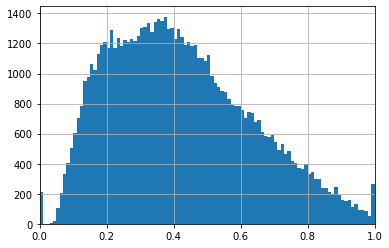

In [42]:
ax = gdf[response].hist(bins=100)
ax.set_xlim((0,1))
plt.show()

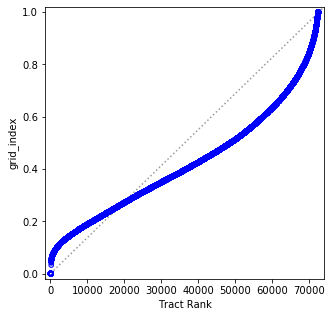

In [43]:
y = gdf[response].sort_values()
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x=range(len(y)), y=y, s=20, marker='o', edgecolor='b', color='none', alpha=0.7)
xmax = int(len(gdf) * 1.02)
xmin = int(len(gdf) * -0.02)
ymax = 1.02
ymin = -0.02
plt.plot([xmin, xmax], [ymin, ymax], c='#999999', ls=':', zorder=-1)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.set_ylabel(response)
ax.set_xlabel('Tract Rank')
plt.show()

In [44]:
print(gdf.groupby('state_abbrev')[[response, 'prop_4way']].median().sort_values('prop_4way').head(10))
print(gdf.groupby('state_abbrev')[[response, 'prop_4way']].median().sort_values('prop_4way').tail(10))

              grid_index  prop_4way
state_abbrev                       
VT              0.133404   0.041848
ME              0.168120   0.053036
WV              0.146079   0.063733
NH              0.163854   0.066398
CT              0.245456   0.083333
AK              0.285602   0.093240
SC              0.196871   0.095384
NC              0.203051   0.095620
KY              0.210008   0.095833
GA              0.227849   0.096774
              grid_index  prop_4way
state_abbrev                       
MN              0.472955   0.208930
WI              0.488544   0.217742
KS              0.542350   0.234471
ND              0.546871   0.242424
NY              0.523570   0.245614
IL              0.567816   0.257874
NE              0.554861   0.261051
IA              0.580245   0.268728
SD              0.581577   0.273522
DC              0.627500   0.366337


In [45]:
# total nodes and edges in dataset 
print('{:,}'.format(gdf['m'].sum()))
print('{:,}'.format(gdf['n'].sum()))

23,535,182
18,942,521


In [46]:
variables = [response, 'straightness', 'orientation_order', 'prop_4way',
             'aland', 'total_pop_k', 'is_urban', 'prop_single_fam', 'med_rooms_per_home', 
             'intersect_density', 'length_mean', 'prop_deadend', 'k_avg',
             'elevations_iqr', 'grade_mean']

gdf[variables].corr()

,grid_index,straightness,orientation_order,prop_4way,aland,total_pop_k,is_urban,prop_single_fam,med_rooms_per_home,intersect_density,length_mean,prop_deadend,k_avg,elevations_iqr,grade_mean
grid_index,1.000000,0.663511,0.899478,0.900373,-0.061336,-0.172701,0.420062,-0.322737,-0.362788,0.570772,-0.265833,-0.735248,0.627165,-0.304589,-0.376600
straightness,0.663511,1.000000,0.576998,0.582524,-0.071352,-0.127675,0.235613,-0.170286,-0.201039,0.412666,-0.178465,-0.509930,0.420942,-0.335524,-0.275154
orientation_order,0.899478,0.576998,1.000000,0.669655,-0.059124,-0.176444,0.368848,-0.259621,-0.343599,0.464109,-0.208365,-0.597286,0.432192,-0.298608,-0.416461
prop_4way,0.900373,0.582524,0.669655,1.000000,-0.048282,-0.155685,0.376180,-0.349536,-0.330311,0.570926,-0.247403,-0.707588,0.632320,-0.225315,-0.250803
aland,-0.061336,-0.071352,-0.059124,-0.048282,1.000000,-0.030221,-0.115287,0.049551,-0.025467,-0.088826,0.246146,0.087171,-0.036672,0.187563,0.008167
total_pop_k,-0.172701,-0.127675,-0.176444,-0.155685,-0.030221,1.000000,0.037791,0.067884,0.130655,-0.104340,-0.104520,0.146656,-0.008911,-0.030125,-0.027474
is_urban,0.420062,0.235613,0.368848,0.376180,-0.115287,0.037791,1.000000,-0.339947,-0.197052,0.659815,-0.581536,-0.479721,0.268726,-0.309795,-0.128730
prop_single_fam,-0.322737,-0.170286,-0.259621,-0.349536,0.049551,0.067884,-0.339947,1.000000,0.695414,-0.469541,0.283493,0.369687,-0.061192,0.147894,0.066503
med_rooms_per_home,-0.362788,-0.201039,-0.343599,-0.330311,-0.025467,0.130655,-0.197052,0.695414,1.000000,-0.325855,0.126951,0.330264,-0.128285,0.065019,0.120163
intersect_density,0.570772,0.412666,0.464109,0.570926,-0.088826,-0.104340,0.659815,-0.469541,-0.325855,1.000000,-0.516077,-0.620596,0.404712,-0.260346,-0.120498


In [47]:
mask_urban = (gdf['state_abbrev'].isin(states)) & (gdf['is_urban'] == 1)
mask_rural = (gdf['state_abbrev'].isin(states)) & (gdf['is_urban'] == 0)
print(gdf[mask_urban][response].median())
print(gdf[mask_rural][response].median())

0.46294668940799033
0.273005777931679


In [48]:
ne = ['ME', 'VT', 'NH', 'MA', 'RI', 'CT', 'NJ', 'PA', 'NY']
mask_urban = (gdf['state_abbrev'].isin(ne)) & (gdf['is_urban'] == 1)
mask_rural = (gdf['state_abbrev'].isin(ne)) & (gdf['is_urban'] == 0)
print(gdf[mask_urban][response].median())
print(gdf[mask_rural][response].median())

0.4852303123331175
0.1812818438855992


In [49]:
plains = ['ND', 'SD', 'NE', 'KS', 'OK']
mask_urban = (gdf['state_abbrev'].isin(plains)) & (gdf['is_urban'] == 1)
mask_rural = (gdf['state_abbrev'].isin(plains)) & (gdf['is_urban'] == 0)
print(gdf[mask_urban][response].median())
print(gdf[mask_rural][response].median())

0.5182428767902837
0.5173990210986679
